INTRODUCTION

As always, before we begin coding, we must load the required libaries for R.

In [23]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(digest)
library(repr)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

## Outline

1. read data, select "Post Hour" and "Likes", "Comments", "Shares"
2. split data
3. create knn regression model
        - find best k in workflow using training data
        - refit the model with test data
4. create simple linear regression model
5. create new tibble with every hour
6. find "Likes", "Comments", "Shares" for each hour using knn regression and linear regression models
7. find hour with highest "Likes", "Comments", "Shares"

Next, we will begin reading the file into JupyterHub. Since the file is retrieved from an outside URL, we will download the file to JupyterHub, and since the cells are seperated by semi-colons, instead of normally reading the file through read_csv, we will read the file by read_csv2.

In [24]:
#reading the data
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip",temp)

#Reading the data in R
facebook <- read_csv2(unz(temp, "dataset_Facebook.csv"))
head(facebook)
unlink(temp)
facebook

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186


Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136
81370,Photo,2,1,4,4,NA,4188,7292,564,524,743,3861,2200,316,0,91,28,119


Looking at our dataset, it passes the test for tidy data (each row is a single observation, each column is a single variable, each value is a single cell), so no further cleaning data tools are required. However, the column names are separated by white spaces instead of underscores (_). To deal with this issue, we will rename our predictor columns to additional headaches along the way. 

In [37]:
#Renaming "Post Hour"
facebook_1 <- facebook %>% rename(post_hour = `Post Hour`) %>% 
    rename(post_day = `Post Weekday`) %>% 
    rename(total_interactions = `Total Interactions`)

As part of our exploratory data analysis, we'll take a quick overview of our predictor variable, plotting "Total Interactions" versus "Post Hour" (Post Hour can be swapped with Post Day or Post Weekday as well) through a scatterplot, just to filter out any potential outliers in our data.

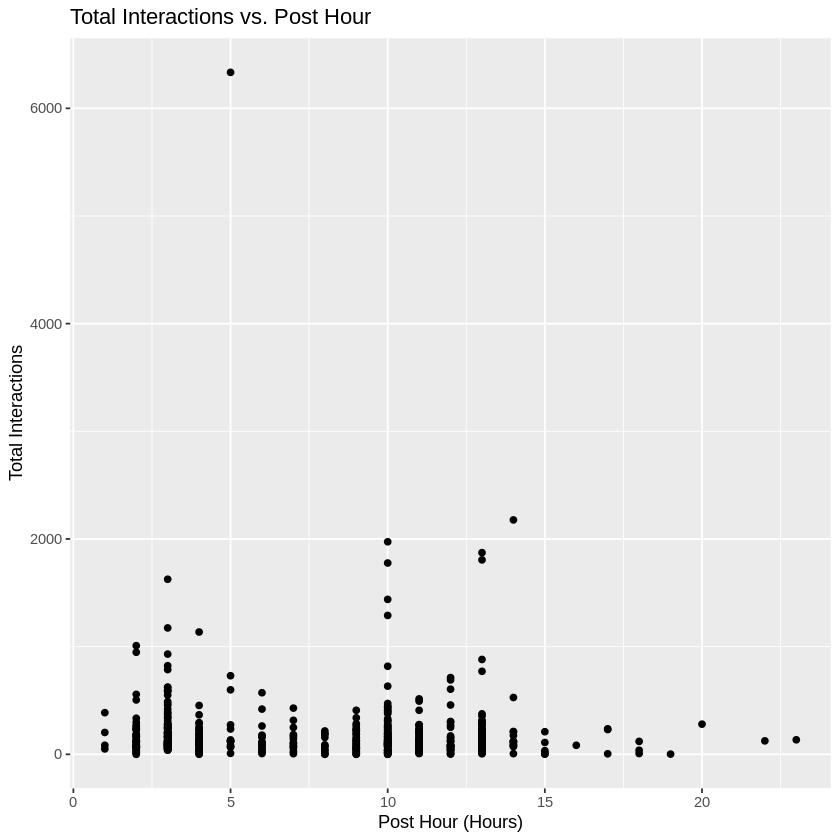

In [38]:
exploratory_scatter_plot <- ggplot(facebook_1, aes(x = post_hour, y = total_interactions)) +
                            geom_point() +
                            labs(x = "Post Hour (Hours)", y = "Total Interactions", title = "Total Interactions vs. Post Hour") 
exploratory_scatter_plot

Hmmm. It seems here that there is one post that more than six thousand total interactions, with only around ten posts that have more than a thousand total interactions. These outliers can cause implications as it can skew the results of our data (large standard deviations) and make our graph look silly, like in the example above. Therefore, lets filter our total interactions to be less than 1000 to retrieve the most optimal results when we perform our regression models.

In [39]:
facebook_filtered2 <- facebook_1 %>% filter(total_interactions < 1000) %>% 
    mutate(hour_of_week = (post_day - 1) * 24 + post_hour)

Next, we'll split the data into training and testing data to perform a quick summary of the training dataset, including the number of rows, the number of columns and the number of rows with missing data values. However, to find to the means to our predictor variables (likes, comments, and shares), we will also need to filter out the number of rows with missing data values, so that we would not encounter any problems (such as a "NA" result) when finding the average. 

In [47]:
#Split into training (75 percent of data set) and test data
set.seed(2021)
facebook_split <- initial_split(facebook_filtered2, prop = 0.75, strata = total_interactions)
facebook_train <- training(facebook_split)
facebook_test <- testing(facebook_split)

facebook_train_filtered <- facebook_train %>%
                         filter(!is.na(col))

#Missing Rows of Data
missing_rows <- sum(colSums(is.na(facebook_train)))

#Average of Each Predictor Variable
average_likes <- mean(facebook_train_filtered[["like"]])
average_comments <- mean(facebook_train_filtered[["comment"]])
average_shares <- mean(facebook_train_filtered[["share"]])
average_total_interactions <- mean(facebook_train_filtered[["total_interactions"]])

#Total Number of Observations
observation_total <- nrow(facebook_train_filtered)

#Total Number of Variables
variable_total <- ncol(facebook_train_filtered)

#Exploratory Data Analysis Table
exploratory_table <- facebook_train_filtered %>%
                     mutate(facebook_train_filtered, observation_total = observation_total) %>%
                     mutate(facebook_train_filtered, variable_total = variable_total) %>%
                     mutate(facebook_train_filtered, average_likes = average_likes) %>%
                     mutate(facebook_train_filtered, average_comments = average_comments) %>%
                     mutate(facebook_train_filtered, average_shares = average_shares) %>%
                     mutate(facebook_train_filtered, average_total_interactions = average_total_interactions) %>%
                     mutate(facebook_train_filtered, missing_rows = missing_rows) %>%
                     select(observation_total, variable_total, average_likes, average_comments, average_shares, average_total_interactions,
                            missing_rows) %>%
                     slice(1)
exploratory_table

Warning message in is.na(col):
“is.na() applied to non-(list or vector) of type 'closure'”


observation_total,variable_total,average_likes,average_comments,average_shares,average_total_interactions,missing_rows
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
368,20,140.0978,5.527174,23.37772,169.0027,0


Decription of us using highest engagment from this point forward.

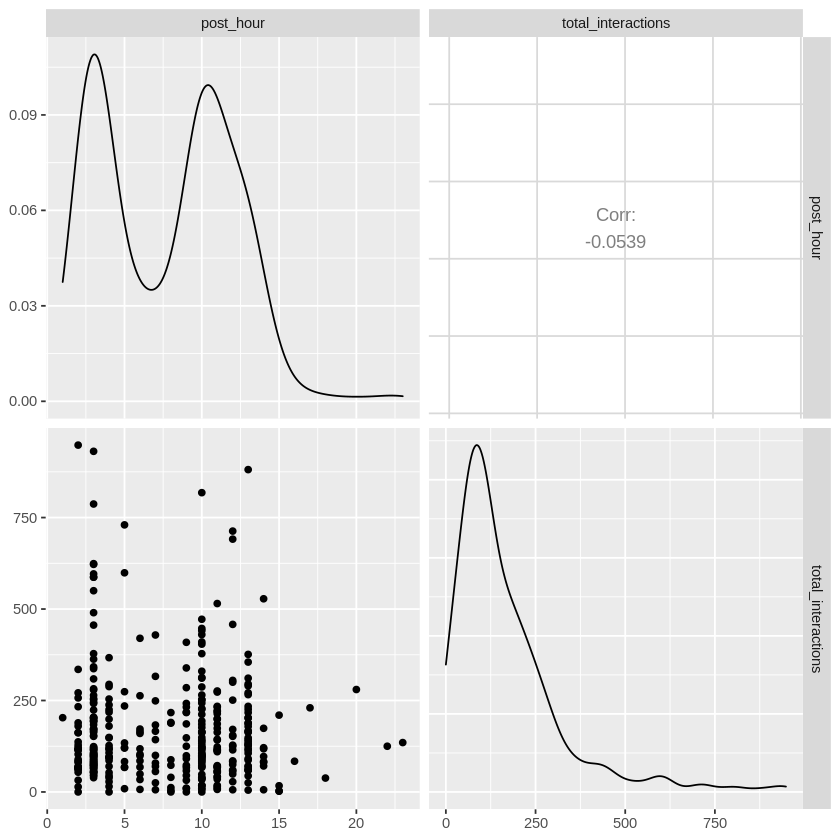

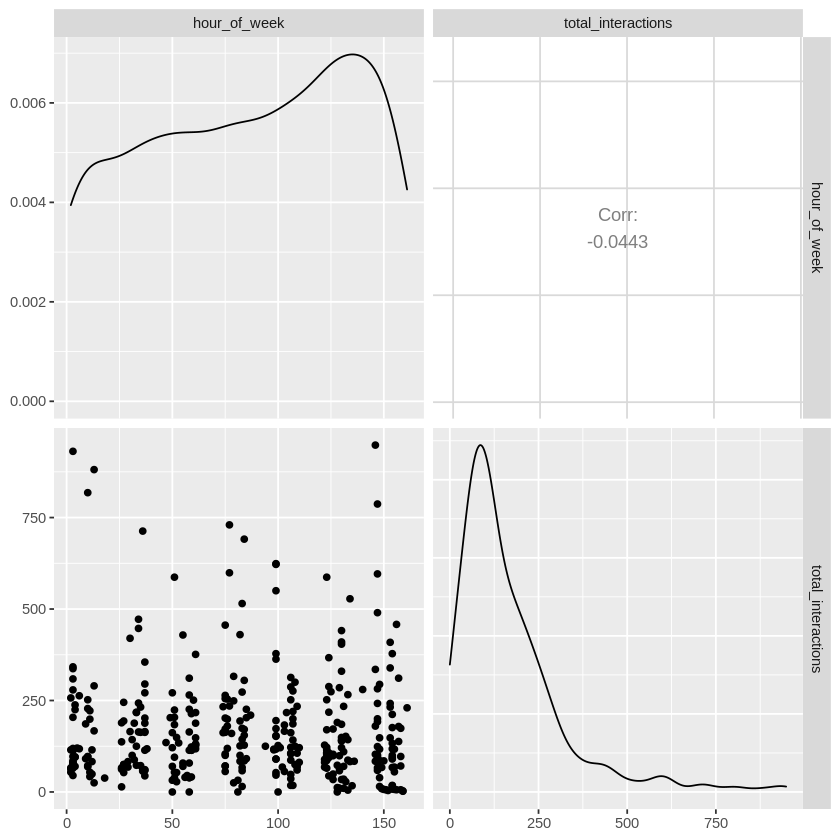

In [28]:
#Ggpairs
facebook_ggpairs <- facebook_train %>%                 
                    select(post_hour, total_interactions) %>%
                    ggpairs()
facebook_ggpairs
facebook_ggpairs2 <- facebook_train %>%
    select(hour_of_week, total_interactions) %>% 
    ggpairs()
facebook_ggpairs2

This makes sense to have no correlation considering there shouldn't be a relationship between post_hour and total_interactions

## Predicting Best Post Hour

In [29]:
set.seed(2021)
#Recipe for Post Hour
facebook_recipe <- recipe(total_interactions ~ hour_of_week, data = facebook_train) %>%
                   step_scale(all_predictors()) %>%
                   step_center(all_predictors())
#Model
facebook_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                 set_engine("kknn") %>%
                 set_mode("regression")

#5 fold cross validation
facebook_vfold <- vfold_cv(facebook_train, v = 5, strata = total_interactions)

#workflow
facebook_workflow <- workflow() %>%
                     add_recipe(facebook_recipe) %>%
                     add_model(facebook_spec)

#testing 200 values to find the best value for K
gridvals <- tibble(neighbors = seq(1, 200))

#Tuning workflow to test the values of K
facebook_results <- facebook_workflow %>%
                        tune_grid(resamples = facebook_vfold, grid = gridvals) %>%
                        collect_metrics()
facebook_rmse <- facebook_results %>% 
    filter(.metric == "rmse") %>% 
    arrange(mean)

facebook_rmse
#Min amount of RMSPE along with mean and standard error to find the best K value to use
facebook_min <- facebook_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean)  %>% 
    slice(1)

facebook_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
68,rmse,standard,153.5240,5,12.61256,Model068
69,rmse,standard,153.5627,5,12.48192,Model069
92,rmse,standard,153.6398,5,12.60842,Model092
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,rmse,standard,170.7963,5,13.05585,Model003
2,rmse,standard,181.6823,5,12.49223,Model002
1,rmse,standard,205.3593,5,15.37514,Model001


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
68,rmse,standard,153.524,5,12.61256,Model068


narration

In [30]:
#Min RMSPE
#set.seed(2021)
k_min <- facebook_min %>%
            pull(neighbors)

#Using the best K in our model
facebook_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
                            set_engine("kknn") %>%
                            set_mode("regression")

#Reworking the workflow to incorporate our chosen K
facebook_best_fit <- workflow() %>%
                        add_recipe(facebook_recipe) %>%
                        add_model(facebook_best_spec) %>%
                        fit(data = facebook_train)

#Summary of the training vs testing data
facebook_summary <- facebook_best_fit %>% 
                       predict(facebook_test) %>%
                       bind_cols(facebook_test) %>%
                       metrics(truth = total_interactions, estimate = .pred)  
facebook_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,157.53008934
rsq,standard,0.07437562
mae,standard,115.09681373


Narration

.pred,Page total likes,Type,Category,Post Month,post_day,post_hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,⋯,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,total_interactions,hour_of_week
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
163.5588,139441,Photo,3,12,3,3,0,2413,4373,⋯,113,154,2812,1503,132,0,66,14,80,51
180.0882,139441,Photo,2,12,2,3,0,7244,13594,⋯,410,580,6228,3200,396,19,325,49,393,27
172.4559,138414,Status,2,12,3,10,0,10060,19680,⋯,1209,1425,17272,8548,1162,4,86,18,108,58
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
161.0147,85979,Link,1,1,5,11,0,45920,5808,⋯,655,763,15766,10720,220,0,128,9,137,107
163.2206,81370,Photo,2,1,5,8,0,3480,6229,⋯,508,687,3961,2104,301,0,53,22,75,104
207.4853,81370,Photo,3,1,4,11,0,4156,7564,⋯,574,832,4534,2452,370,7,91,38,136,83


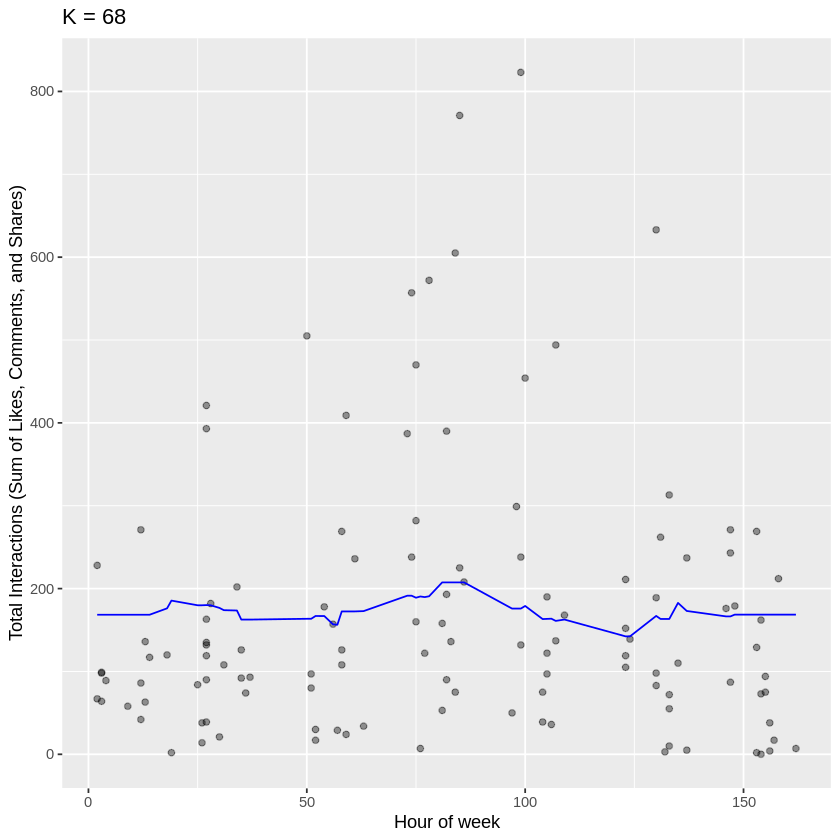

In [48]:
#set.seed(2021)
facebook_preds <- facebook_best_fit %>%
                   predict(facebook_test) %>%
                   bind_cols(facebook_test)
facebook_preds
facebook_plot_final <- ggplot(facebook_preds, aes(x = hour_of_week, y = total_interactions)) +
                       geom_point(alpha = 0.4) +
                       xlab("Hour of week") +
                      ylab("Total Interactions (Sum of Likes, Comments, and Shares)") +
                      geom_line(data = facebook_preds, aes(x = hour_of_week, y = .pred), color = "blue") +
                      ggtitle(paste0("K = ", k_min))
facebook_plot_final

In [32]:
summary(facebook_preds)

     .pred       Page total likes     Type              Category    
 Min.   :142.3   Min.   : 81370   Length:120         Min.   :1.000  
 1st Qu.:166.4   1st Qu.:103580   Class :character   1st Qu.:1.000  
 Median :168.6   Median :128032   Mode  :character   Median :2.000  
 Mean   :173.6   Mean   :120672                      Mean   :1.775  
 3rd Qu.:179.9   3rd Qu.:136393                      3rd Qu.:2.250  
 Max.   :207.5   Max.   :139441                      Max.   :3.000  
                                                                    
   Post Month        post_day       post_hour       Paid       
 Min.   : 1.000   Min.   :1.000   Min.   : 1   Min.   :0.0000  
 1st Qu.: 3.000   1st Qu.:2.000   1st Qu.: 3   1st Qu.:0.0000  
 Median : 7.000   Median :4.000   Median : 9   Median :0.0000  
 Mean   : 6.692   Mean   :4.058   Mean   : 8   Mean   :0.3083  
 3rd Qu.:10.000   3rd Qu.:6.000   3rd Qu.:12   3rd Qu.:1.0000  
 Max.   :12.000   Max.   :7.000   Max.   :19   Max.   :1.0000  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.611589e+02
rsq,standard,1.174392e-03
mae,standard,1.171512e+02


.pred,Page total likes,Type,Category,Post Month,post_day,post_hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,⋯,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,total_interactions,hour_of_week
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
173.7486,139441,Photo,3,12,3,3,0,2413,4373,⋯,113,154,2812,1503,132,0,66,14,80,51
177.0925,139441,Photo,2,12,2,3,0,7244,13594,⋯,410,580,6228,3200,396,19,325,49,393,27
172.7733,138414,Status,2,12,3,10,0,10060,19680,⋯,1209,1425,17272,8548,1162,4,86,18,108,58
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
165.9462,85979,Link,1,1,5,11,0,45920,5808,⋯,655,763,15766,10720,220,0,128,9,137,107
166.3642,81370,Photo,2,1,5,8,0,3480,6229,⋯,508,687,3961,2104,301,0,53,22,75,104
169.2901,81370,Photo,3,1,4,11,0,4156,7564,⋯,574,832,4534,2452,370,7,91,38,136,83


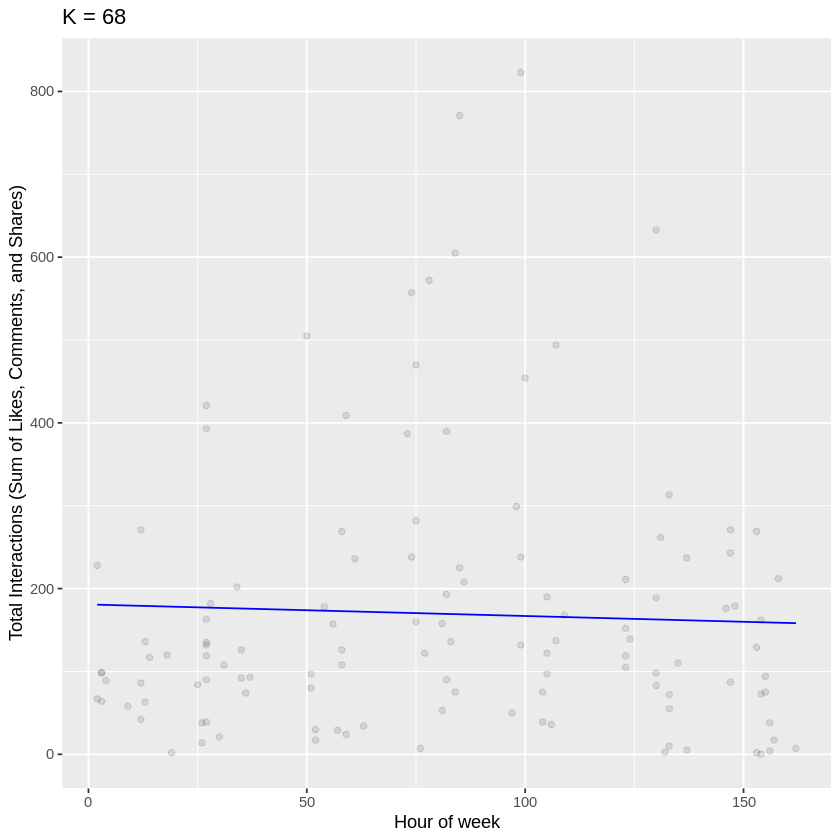

In [33]:
fb_spec <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

fb_recipe <- recipe(total_interactions ~ hour_of_week, data = facebook_train)

fb_fit <- workflow() %>%
    add_recipe(fb_recipe) %>%
    add_model(fb_spec) %>%
    fit(data = facebook_train)

fb_test_results <- fb_fit %>%
    predict(facebook_test) %>%
    bind_cols(facebook_test) %>%
    metrics(truth = total_interactions, estimate = .pred)
fb_test_results

facebook_linear_preds <- fb_fit %>%
                   predict(facebook_test) %>%
                   bind_cols(facebook_test)
facebook_linear_preds
facebook_plot_final <- ggplot(facebook_linear_preds, aes(x = hour_of_week, y = total_interactions)) +
                       geom_point(alpha = 0.1) +
                       xlab("Hour of week") +
                       ylab("Total Interactions (Sum of Likes, Comments, and Shares)") +
                       geom_line(data = facebook_linear_preds, aes(x = hour_of_week, y = .pred), color = "blue") +
                       ggtitle(paste0("K = ", k_min))
facebook_plot_final